# Akhil Potla (ap44876)

# Model 1 US

In [1]:
import sys
sys.path.insert(0,'../')

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from data import plot_countries_all_plus_normalize_1 as plot
from data import save_country_data_1 as save

# import models
from models import model1, model2, model3

df = pd.read_csv('../../data/datasets/time-series-19-covid-combined.csv')

In [24]:
df_US = pd.read_csv('./US.csv', header=None)
calibration_US, validation_US = df_US.iloc[:50], df_US.iloc[50:]


calibration_times = calibration_US[0].to_numpy()
validation_times = validation_US[0].to_numpy()

The following code is based on this [tutorial](https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a) and the starter code for the models [provided by Prashant.](https://github.com/prashjha/StudyCovid19)

Model 1 is imported from [this file.](./models.py)

The description for model 1 is from [this file.](./Different%20models.ipynb)

Model 1 has two parameters that we need to tune for the scenario, $r$ and $p$. These two parameters together will be represented using $\theta$, where $\theta = (r, p)$


## Noise

We assume Gaussian noise for the model. With an average $\mu = 0$ and a standard deviation $\sigma$, which will be selected during calibration and validation by calculating the standard deviation of the samples for their respective steps.


## Prior

The prior for the parameters in $\theta$ is considered to be uniform.

- $r$ is nonnegative value.
- $p$ is any value $[0, 1]$

We essure that the value for both $r$ and $p$ is valid. If either of the values is not valid it returns zero, otherwise it returns 1.


## Likelihood

We assume a Gaussian likelihood function.

\begin{align}
\pi_{like}(y|\theta) \propto exp[-\frac{||Y-C(\theta)||^2}{2\sigma^2}]
\end{align}

- $C(\theta)$ is the output of the model with parameter $\theta$.
- $||Y-C(\theta)||^2$ is the squred norm of $|Y-C(\theta)|$

We take the logarithm of the likelihood function because it is more efficient.

\begin{align}
\log(\pi_{like}(Y|\theta)) \propto -\frac{1}{2\sigma}\sum_{i=1}^{N} |y_i-C(t_i;\theta)|^2
\end{align}


## Posterior

\begin{align}
\pi_{post}(\theta|Y) = \frac{\pi_{like}(Y|\theta)\pi_{prior}(\theta)}{\pi_{evidence}(Y)}
\end{align}

Since the evidence is very difficult to compute, we use MCMC, so we can simplify.

\begin{align}
\pi_{post}(\theta|Y) \propto \pi_{like}(Y|\theta)\pi_{prior}(\theta)
\end{align}

We take the logarithm because it is more efficient. 

\begin{align}
\log(\pi_{post}(\theta|Y)) \propto log(\pi_{like}(Y|\theta))+log(\pi_{prior}(\theta))
\end{align}

## Calibration

During the calibration step we take the data from the first 50 days and we use it to calibrate the values of the model parameters. The parameters of this model are `r` and `p`. These two parameters together will be represented using $\theta$, where $\theta = (r, p)$

For that we select a transition model to take us from one state to another. The transition model selects the values for `r` and `p` based on the previous value for `r` and `p` and given a reasonable standard deviation. We use a Gaussian/Normal distribution to randomly select the next value for these parameters.

In [3]:
calibration_cases = calibration_US[1].to_numpy()
calibration_noise = np.std(calibration_cases)
n_iter = 50000

In [4]:
transition_model1 = lambda theta: [np.random.normal(theta[0], 0.1), np.random.normal(theta[1], 0.01)]

def prior(theta):
    if (theta[0] < 1.e-5 or theta[1] <= 1.e-5):
        return 1.e-8
    elif theta[1] >= (1 - 1.e-5):
        return 1.e-8
    else:
        return 1

# likelihood
def log_lik(theta, model, t, data, fix_params, noise_sigma):
    # get model output
    C = model(theta, t, fix_params)
    # log likelihood
    b = data - C
    return (-1. / (2. * noise_sigma * noise_sigma)) * np.linalg.norm(data - C) ** 2

def acceptance(theta, theta_new):
    if theta_new > theta:
        return True
    else:
        accept = np.random.uniform(0, 1)
        return (accept < (np.exp(theta_new - theta)))

def metropolis_hastings(model, likelihood, prior, transition_model, param_init, iterations, 
                        t, data, fix_params, acceptance_rule, noise_sigma):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []
    num_accepted = []
    for i in range(iterations):
        x_new = transition_model(x)    
        x_lik = likelihood(x, model, t, data, fix_params, noise_sigma)
        x_new_lik = likelihood(x_new, model, t, data, fix_params, noise_sigma) 
        if (acceptance_rule(x_lik + np.log(prior(x)),
                            x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)
                
    return np.array(accepted), np.array(rejected)

We run the Metropolis Hastings Algorithm 50,000 times, and we burn the first 80% of the accepted trials.

In [6]:
accepted, rejected = metropolis_hastings(model1, log_lik, prior, transition_model1, [0., 0.], n_iter,
                                         calibration_times, calibration_cases, [1, 100], acceptance, calibration_noise)
print('Number of Accepted: ', len(accepted))
after_burn_in = int(len(accepted) * 0.8)
accepted = accepted.T

Number of Accepted:  5125


In [7]:
r = accepted[0, after_burn_in:]
p = accepted[1, after_burn_in:]
r_average = np.average(r)
r_std = np.std(r)
p_average = np.average(p)
p_std = np.std(p)

R average:  0.1810073008676782
R std:  0.05068135528198024
P average:  0.9235651215065477
P std:  0.07044537382761534


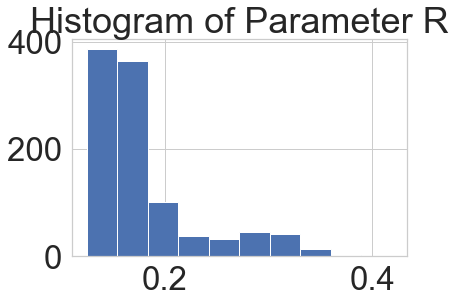

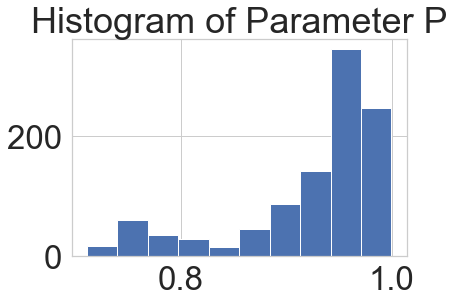

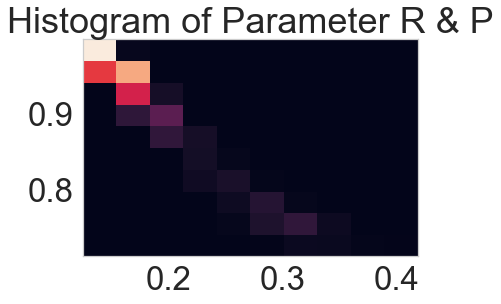

In [8]:
plt.hist(r)
plt.title('Histogram of Parameter R')
plt.figure()
plt.hist(p)
plt.title('Histogram of Parameter P')
plt.figure()
plt.hist2d(r, p)
plt.title('Histogram of Parameter R & P')

print('R average: ', r_average)
print('R std: ', r_std)
print('P average: ', p_average)
print('P std: ', p_std)

In [9]:
t = [float(i) for i in range(84)]
T = 100.
C_0 = 1.

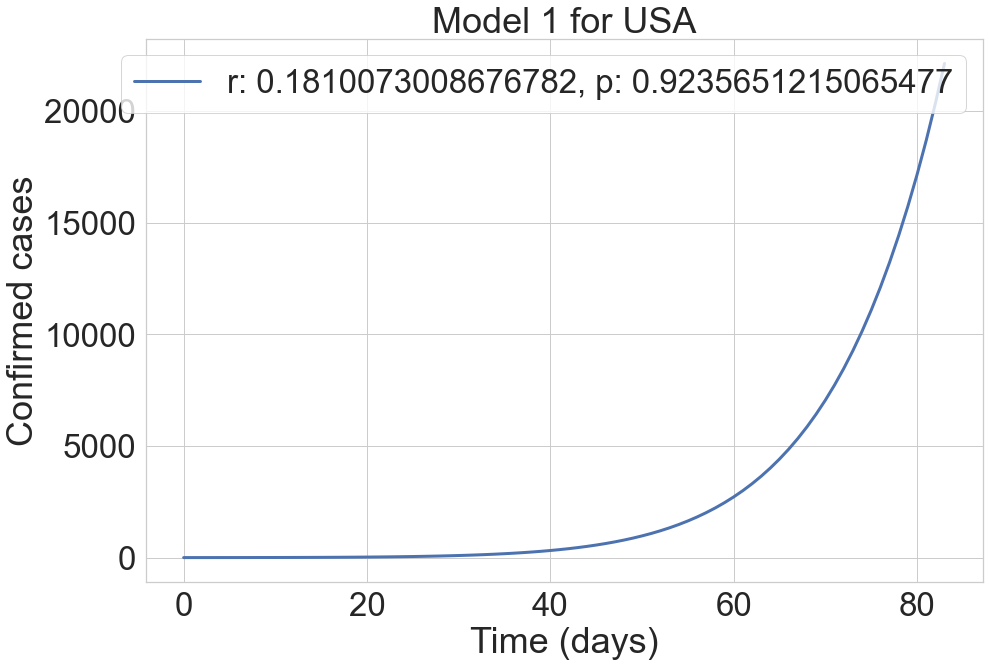

In [10]:
C = model1([r_average, p_average], t, [C_0, T])
fig = plt.figure(figsize=(15., 10.))
plt.plot(t, C, label='r: {}, p: {}'.format(r_average, p_average))
plt.title('Model 1 for USA')
plt.xlabel('Time (days)')
plt.ylabel('Confirmed cases')
plt.legend()

## Validation

In [11]:
validation_cases = validation_US[1].to_numpy()
validation_noise = np.std(calibration_cases)
cov = np.cov([r, p])
mu = np.array([r_average, p_average])

In [12]:
transition_model1 = lambda theta: [np.random.normal(theta[0], r_std), np.random.normal(theta[1], p_std)]

def prior_val(theta):
    if (theta[0] < 1.e-5 or theta[1] <= 1.e-5):
        return 1.e-8
    elif theta[1] >= (1 - 1.e-5):
        return 1.e-8
    else:
        return scipy.stats.multivariate_normal.pdf(theta, mean=mu, cov=cov)

We run the Metropolis Hastings Algorithm 50,000 times, and we burn the first 80% of the accepted trials.

In [13]:
val_accepted, val_rejected = metropolis_hastings(model1, log_lik, prior_val, transition_model1, [r_average, p_average],
                                         n_iter, validation_times, validation_cases, [1, 100], acceptance, validation_noise)
after_burn_in = int(len(val_accepted) * 0.8)
val_accepted = val_accepted.T

In [14]:
val_r = val_accepted[0, after_burn_in:]
val_p = val_accepted[1, after_burn_in:]
val_r_average = np.average(val_r)
val_r_std = np.std(val_r)
val_p_average = np.average(val_p)
val_p_std = np.std(val_p)

R average:  0.3513542586919303
R std:  0.000850071655461424
P average:  0.896248239690765
P std:  0.0002957058087295114


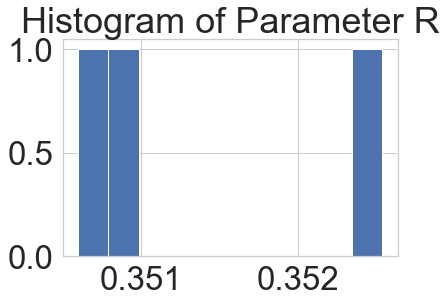

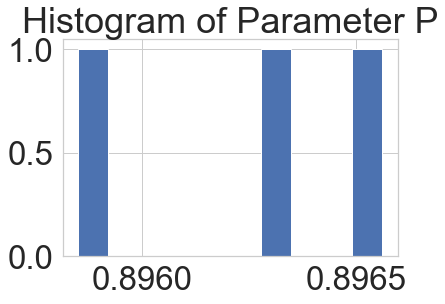

In [15]:
plt.figure()
plt.hist(val_r)
plt.title('Histogram of Parameter R')
plt.figure()
plt.hist(val_p)
plt.title('Histogram of Parameter P')

print('R average: ', val_r_average)
print('R std: ', val_r_std)
print('P average: ', val_p_average)
print('P std: ', val_p_std)

In [20]:
t = [float(i) for i in range(84)]
T = 100.
C_0 = 1.

In [26]:
C = model1([val_r_average, val_p_average], t, [C_0, T])
print('r2_score: ', r2_score(C[50:], validation_cases))

r2_score:  0.9725454490704682


## Prediction

We take the validation parameters and their standard deviations, then we sample a prediction.

In [16]:
def model1_prediction_sampler(theta, theta_std, iterations):
    r = theta[0]
    p = theta[1]
    
    r_std = theta_std[0]
    p_std = theta_std[1]
    
    T = 100
    C_0 = 1
    
    predictions = []
    for i in range(iterations):
        r_i = np.random.normal(r, r_std)
        p_i = np.random.normal(p, p_std)
        prediction = model1([r_i, p_i], [T], [C_0])
        if prediction in [np.inf] or prediction < 0:
            continue
        elif prediction > 1e8:
            continue
        predictions.append(prediction)
        
    return predictions

We run the prediction 50,000 times, and we burn the first 80% of the accepted trials.

In [17]:
predictions = model1_prediction_sampler([val_r_average, val_p_average], [val_r_std, val_p_std], n_iter)

In [18]:
predictions = np.array(predictions)
predictions = predictions.T
after_burn_in = int(len(predictions) * 0.8)
predictions = predictions[after_burn_in:]

In [19]:
print(int(model1([val_r_average, val_p_average], [T], [C_0, T])))
print(int(np.average(predictions)))

2685315
2686550


The prediction from the model using just the validation parameters is 2,685,315 total cases on the 100th day in the US. The prediction from the model using the samples is 2,668,550 total cases on the 100th day in the US.